### 실행 위치: input/code/mmsegmentation/inference.ipynb
### 바꿔줘야 하는 부분: 
1. config & checkpoint file 경로
2. 맨 마지막에 저장할 submission 파일 이름

### config & checkpoint file

In [1]:
config_file = './work_dirs/ocr_hr/ocr_hr.py'
checkpoint_file = './work_dirs/ocr_hr/best_mIoU_epoch_38_0.pth'
batch_size = 8

In [2]:
import argparse
import os
import os.path as osp
import shutil
import time
import warnings
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

#!pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.patches import Patch

import webcolors
plt.rcParams['axes.grid'] = False

import mmcv
import torch
from torch.utils.data import Dataset, DataLoader
from mmcv import Config
from mmcv.cnn.utils import revert_sync_batchnorm
from mmcv.parallel import MMDataParallel, MMDistributedDataParallel
from mmcv.runner import (get_dist_info, init_dist, load_checkpoint,
                         wrap_fp16_model)
from mmcv.utils import DictAction

from mmseg import digit_version
from mmseg.apis import multi_gpu_test, single_gpu_test, inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.datasets import build_dataloader, build_dataset
from mmseg.models import build_segmentor
from mmseg.utils import setup_multi_processes
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
class_colormap = pd.read_csv("../class_dict.csv")

def create_trash_label_colormap():
    """Creates a label colormap used in Trash segmentation.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for inex, (_, r, g, b) in enumerate(class_colormap.values):
        colormap[inex] = [r, g, b]
    
    return colormap

def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
                is the color indexed by the corresponding element in the input label
                to the trash color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
              map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

def plot_examples(batch_size, batch_idx, mode):
    category_and_rgb = [[category, (r,g,b)] for idx, (category, r, g, b) in enumerate(class_colormap.values)]
    legend_elements = [Patch(facecolor=webcolors.rgb_to_hex(rgb), 
                             edgecolor=webcolors.rgb_to_hex(rgb), 
                             label=category) for category, rgb in category_and_rgb]
    if mode == 'val':
        with torch.no_grad():
            for index, infos in enumerate(data_loader):
                if index != batch_idx:
                    continue
                multi_512_idx = 0 if len(infos['img'])==1 else len(infos['img'])//2
                fig, ax = plt.subplots(nrows=batch_size, ncols=3, figsize=(12, 4*batch_size), constrained_layout=True)
                for i in range(batch_size):
                    img = infos['img'][multi_512_idx][i]
                    mask = infos['gt_semantic_seg'][multi_512_idx][i]
                    # print(mask.shape)
                    ax[i][0].imshow(torch.stack([img[0]*58.395 + 123.675,img[1]*57.12+116.28,img[2]*57.375+103.53]).type(torch.LongTensor).permute((1,2,0)))
                    ax[i][0].set_title(f"Orignal Image")
                    ax[i][1].imshow(label_to_color_image(mask.detach().cpu().numpy().squeeze()))
                    ax[i][1].set_title(f"Ground Truth")
                    ax[i][2].imshow(label_to_color_image(val_results[batch_size*batch_idx+i]))
                    ax[i][2].set_title(f"Pred Mask")
                    ax[i][2].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
                plt.show()
    elif mode == 'test':
        with torch.no_grad():
            for index, infos in enumerate(test_data_loader):
                if index != batch_idx:
                    continue
                multi_512_idx = 0 if len(infos['img'])==1 else len(infos['img'])//2
                fig, ax = plt.subplots(nrows=batch_size, ncols=2, figsize=(12, 4*batch_size), constrained_layout=True)
                for i in range(batch_size):
                    img = infos['img'][multi_512_idx][i]
                    # print(mask.shape)
                    ax[i][0].imshow(torch.stack([img[0]*58.395 + 123.675,img[1]*57.12+116.28,img[2]*57.375+103.53]).type(torch.LongTensor).permute((1,2,0)))
                    ax[i][0].set_title(f"Orignal Image")
                    ax[i][1].imshow(label_to_color_image(test_results[batch_size*batch_idx+i]))
                    ax[i][1].set_title(f"Pred Mask")
                    ax[i][1].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
                plt.show()

### valid set inference & visualize

In [7]:
cfg = Config.fromfile(config_file)
if cfg.get('cudnn_benchmark', False):
    torch.backends.cudnn.benchmark = True

cfg.model.pretrained = None
dataset = build_dataset(cfg.data.val)
# The default loader config
loader_cfg = dict(
    # cfg.gpus will be ignored if distributed
    num_gpus=len(cfg.gpu_ids),
    shuffle=False)
# The overall dataloader settings
loader_cfg.update({
    k: v
    for k, v in cfg.data.items() if k not in [
        'train', 'val', 'test', 'train_dataloader', 'val_dataloader',
        'test_dataloader'
    ]
})

val_loader_cfg = {
    **loader_cfg,
    'samples_per_gpu': batch_size,
    'shuffle': False,  # Not shuffle by default
    **cfg.data.get('val_dataloader', {})
}

data_loader = build_dataloader(dataset, **val_loader_cfg)
cfg.model.train_cfg = None

model = build_segmentor(cfg.model, test_cfg=cfg.get('test_cfg'))
checkpoint = load_checkpoint(model, checkpoint_file, map_location='cpu')
model = MMDataParallel(model, device_ids=cfg.gpu_ids)
model.eval()

# inference 수행
val_results = single_gpu_test(model, data_loader)

2022-05-01 05:47:29,889 - mmseg - INFO - Loaded 655 images


load checkpoint from local path: ./work_dirs/ocr_hr/best_mIoU_epoch_38_0.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 655/655, 15.3 task/s, elapsed: 43s, ETA:     0s

In [8]:
# annotation load를 위한 data loader 재정의
cfg = Config.fromfile(config_file)
if cfg.get('cudnn_benchmark', False):
    torch.backends.cudnn.benchmark = True

cfg.model.pretrained = None
cfg.data.val.pipeline.insert(1,{'type': 'LoadAnnotations'})
cfg.data.val.pipeline[-1]['transforms'][-2]['keys'].append('gt_semantic_seg')
cfg.data.val.pipeline[-1]['transforms'][-1]['keys'].append('gt_semantic_seg')

dataset = build_dataset(cfg.data.val)
# The default loader config
loader_cfg = dict(
    # cfg.gpus will be ignored if distributed
    num_gpus=len(cfg.gpu_ids),
    shuffle=False)
# The overall dataloader settings
loader_cfg.update({
    k: v
    for k, v in cfg.data.items() if k not in [
        'train', 'val', 'test', 'train_dataloader', 'val_dataloader',
        'test_dataloader'
    ]
})

val_loader_cfg = {
    **loader_cfg,
    'samples_per_gpu': batch_size,
    'shuffle': False,  # Not shuffle by default
    **cfg.data.get('val_dataloader', {})
}

data_loader = build_dataloader(dataset, **val_loader_cfg)

2022-05-01 05:48:19,010 - mmseg - INFO - Loaded 655 images


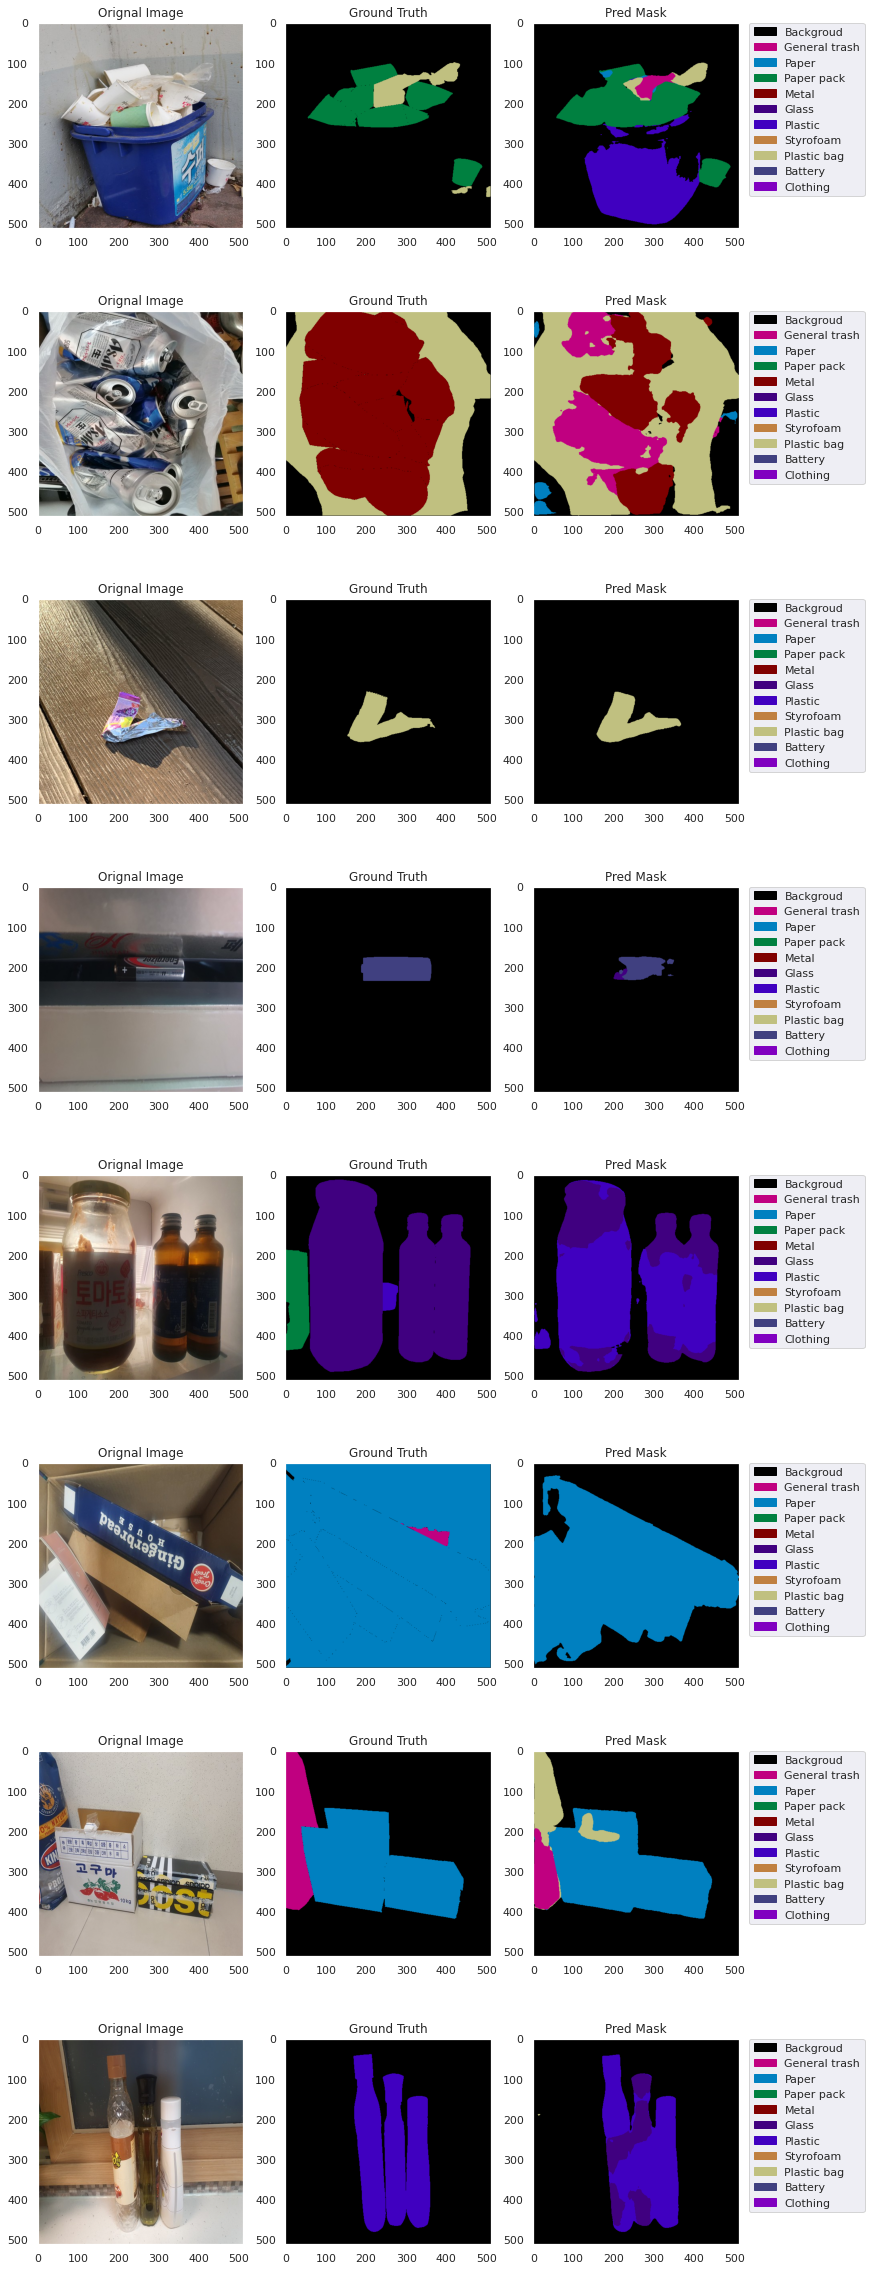

In [9]:
# batch_idx 를 바꿔가며 결과 확인
plot_examples(batch_size=batch_size, batch_idx=2, mode='val')

### test set inference & visualize

In [10]:
cfg = Config.fromfile(config_file)
device = "cuda" if torch.cuda.is_available() else "cpu"
if cfg.get('cudnn_benchmark', False):
    torch.backends.cudnn.benchmark = True

cfg.model.pretrained = None
cfg.data.test.test_mode = True

test_dataset = build_dataset(cfg.data.test)
# The default loader config
loader_cfg = dict(
    # cfg.gpus will be ignored if distributed
    num_gpus=len(cfg.gpu_ids),
    shuffle=False)
# The overall dataloader settings
loader_cfg.update({
    k: v
    for k, v in cfg.data.items() if k not in [
        'train', 'val', 'test', 'train_dataloader', 'val_dataloader',
        'test_dataloader'
    ]
})
test_loader_cfg = {
    **loader_cfg,
    'samples_per_gpu': batch_size,
    'shuffle': False,  # Not shuffle by default
    **cfg.data.get('test_dataloader', {})
}
# build the dataloader
test_data_loader = build_dataloader(test_dataset, **test_loader_cfg)
cfg.model.train_cfg = None

model = build_segmentor(cfg.model, test_cfg=cfg.get('test_cfg'))
checkpoint = load_checkpoint(model, checkpoint_file, map_location='cpu')
model = MMDataParallel(model, device_ids=cfg.gpu_ids)
model.eval()

# inference 수행
test_results = single_gpu_test(model, test_data_loader)

2022-05-01 05:48:51,114 - mmseg - INFO - Loaded 624 images


load checkpoint from local path: ./work_dirs/ocr_hr/best_mIoU_epoch_38_0.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 624/624, 17.5 task/s, elapsed: 36s, ETA:     0s

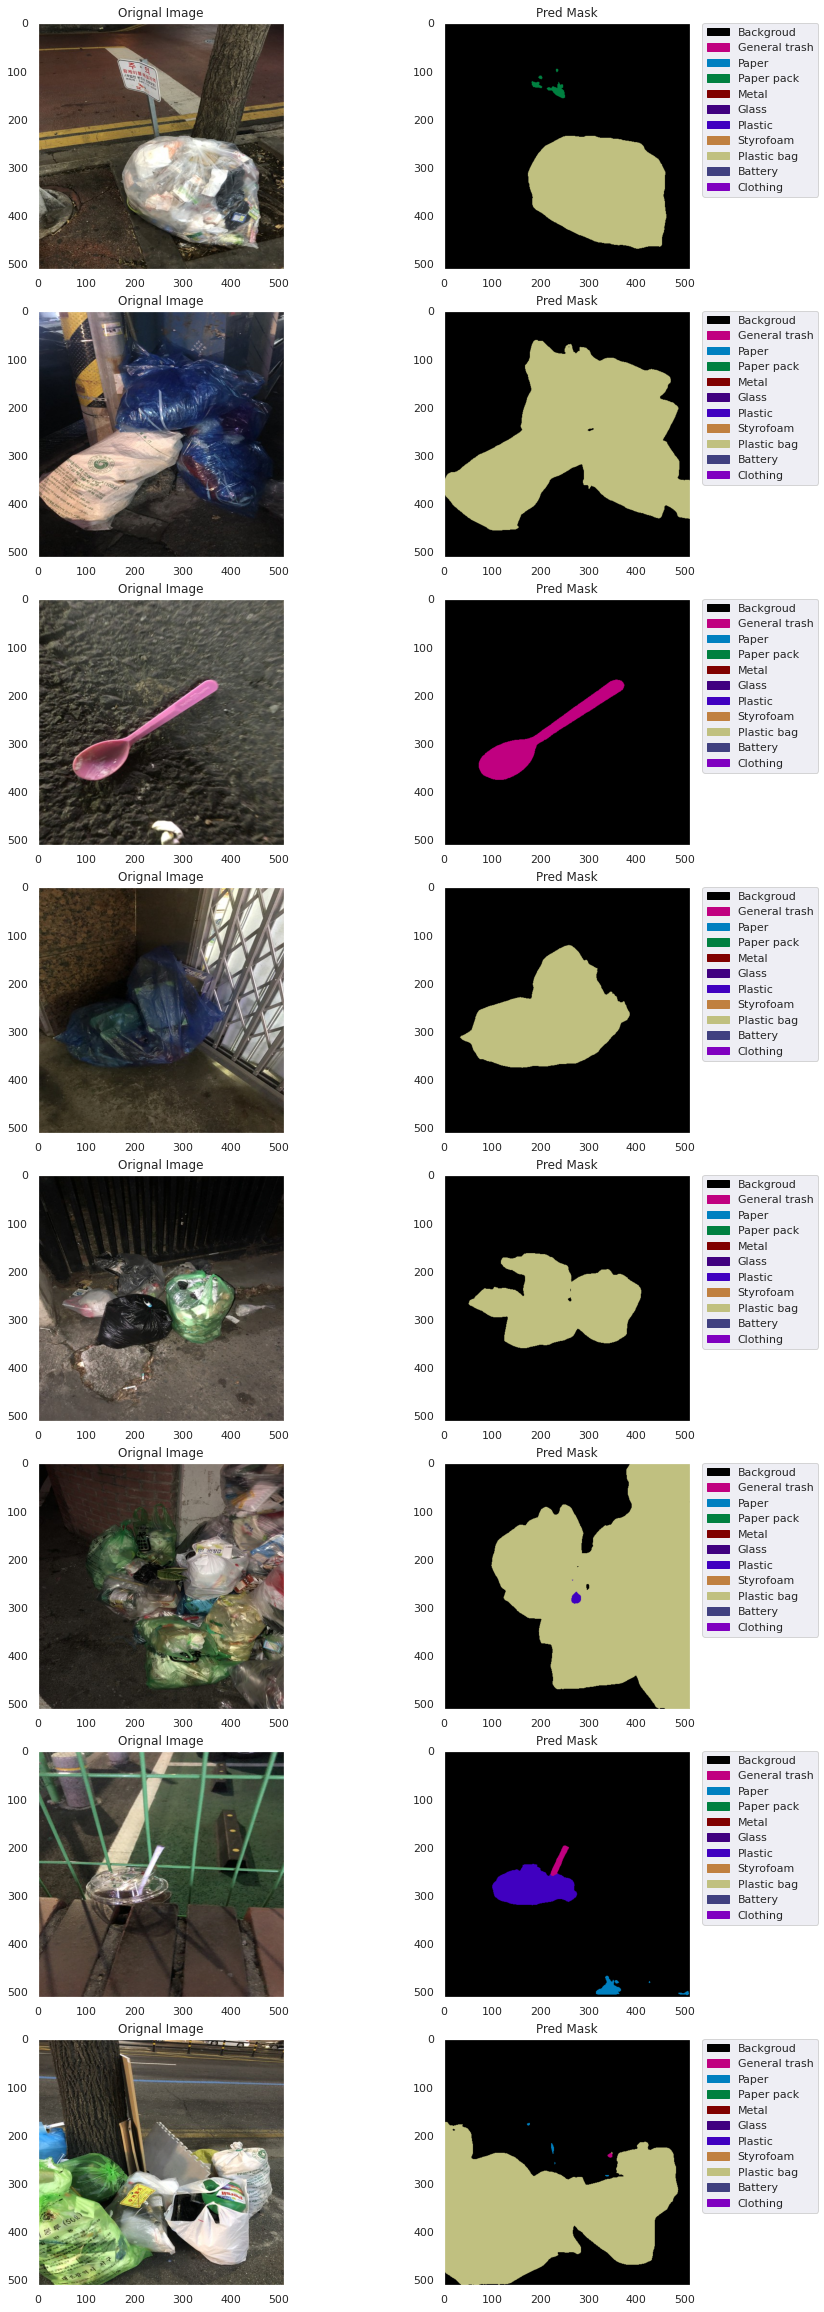

In [11]:
# batch_idx 를 바꿔가며 결과 확인
plot_examples(batch_size=batch_size, batch_idx=0, mode='test')

### submission.csv 생성

In [12]:
file_names = ['batch_01_vt/0021.jpg',
 'batch_01_vt/0028.jpg',
 'batch_01_vt/0031.jpg',
 'batch_01_vt/0032.jpg',
 'batch_01_vt/0076.jpg',
 'batch_01_vt/0078.jpg',
 'batch_01_vt/0096.jpg',
 'batch_01_vt/0101.jpg',
 'batch_01_vt/0122.jpg',
 'batch_01_vt/0131.jpg',
 'batch_01_vt/0144.jpg',
 'batch_01_vt/0173.jpg',
 'batch_01_vt/0186.jpg',
 'batch_01_vt/0198.jpg',
 'batch_01_vt/0206.jpg',
 'batch_01_vt/0213.jpg',
 'batch_01_vt/0216.jpg',
 'batch_01_vt/0234.jpg',
 'batch_01_vt/0249.jpg',
 'batch_01_vt/0251.jpg',
 'batch_01_vt/0253.jpg',
 'batch_01_vt/0281.jpg',
 'batch_01_vt/0289.jpg',
 'batch_01_vt/0305.jpg',
 'batch_01_vt/0310.jpg',
 'batch_01_vt/0331.jpg',
 'batch_01_vt/0338.jpg',
 'batch_01_vt/0341.jpg',
 'batch_01_vt/0346.jpg',
 'batch_01_vt/0367.jpg',
 'batch_01_vt/0369.jpg',
 'batch_01_vt/0377.jpg',
 'batch_01_vt/0389.jpg',
 'batch_01_vt/0395.jpg',
 'batch_01_vt/0459.jpg',
 'batch_01_vt/0464.jpg',
 'batch_01_vt/0479.jpg',
 'batch_01_vt/0494.jpg',
 'batch_01_vt/0512.jpg',
 'batch_01_vt/0519.jpg',
 'batch_01_vt/0522.jpg',
 'batch_01_vt/0541.jpg',
 'batch_01_vt/0584.jpg',
 'batch_01_vt/0585.jpg',
 'batch_01_vt/0599.jpg',
 'batch_01_vt/0621.jpg',
 'batch_01_vt/0623.jpg',
 'batch_01_vt/0632.jpg',
 'batch_01_vt/0649.jpg',
 'batch_01_vt/0659.jpg',
 'batch_01_vt/0670.jpg',
 'batch_01_vt/0703.jpg',
 'batch_01_vt/0707.jpg',
 'batch_01_vt/0708.jpg',
 'batch_01_vt/0726.jpg',
 'batch_01_vt/0729.jpg',
 'batch_01_vt/0739.jpg',
 'batch_01_vt/0750.jpg',
 'batch_01_vt/0751.jpg',
 'batch_01_vt/0753.jpg',
 'batch_01_vt/0760.jpg',
 'batch_01_vt/0761.jpg',
 'batch_01_vt/0764.jpg',
 'batch_01_vt/0775.jpg',
 'batch_01_vt/0780.jpg',
 'batch_01_vt/0785.jpg',
 'batch_01_vt/0786.jpg',
 'batch_01_vt/0791.jpg',
 'batch_01_vt/0798.jpg',
 'batch_01_vt/0837.jpg',
 'batch_01_vt/0838.jpg',
 'batch_01_vt/0839.jpg',
 'batch_01_vt/0849.jpg',
 'batch_01_vt/0857.jpg',
 'batch_01_vt/0862.jpg',
 'batch_01_vt/0864.jpg',
 'batch_01_vt/0870.jpg',
 'batch_01_vt/0902.jpg',
 'batch_01_vt/0903.jpg',
 'batch_01_vt/0904.jpg',
 'batch_01_vt/0916.jpg',
 'batch_01_vt/0925.jpg',
 'batch_01_vt/0944.jpg',
 'batch_01_vt/0951.jpg',
 'batch_01_vt/0964.jpg',
 'batch_01_vt/0968.jpg',
 'batch_01_vt/0985.jpg',
 'batch_01_vt/0986.jpg',
 'batch_01_vt/0988.jpg',
 'batch_01_vt/0990.jpg',
 'batch_01_vt/1011.jpg',
 'batch_01_vt/1012.jpg',
 'batch_01_vt/1018.jpg',
 'batch_01_vt/1040.jpg',
 'batch_01_vt/1047.jpg',
 'batch_01_vt/1051.jpg',
 'batch_01_vt/1055.jpg',
 'batch_01_vt/1057.jpg',
 'batch_01_vt/1059.jpg',
 'batch_01_vt/1064.jpg',
 'batch_01_vt/1078.jpg',
 'batch_01_vt/1079.jpg',
 'batch_01_vt/1081.jpg',
 'batch_01_vt/1085.jpg',
 'batch_01_vt/1092.jpg',
 'batch_01_vt/1111.jpg',
 'batch_01_vt/1123.jpg',
 'batch_01_vt/1126.jpg',
 'batch_01_vt/1129.jpg',
 'batch_01_vt/1136.jpg',
 'batch_01_vt/1141.jpg',
 'batch_01_vt/1153.jpg',
 'batch_01_vt/1166.jpg',
 'batch_01_vt/1174.jpg',
 'batch_01_vt/1178.jpg',
 'batch_01_vt/1184.jpg',
 'batch_01_vt/1192.jpg',
 'batch_01_vt/1197.jpg',
 'batch_01_vt/1210.jpg',
 'batch_01_vt/1213.jpg',
 'batch_01_vt/1230.jpg',
 'batch_01_vt/1237.jpg',
 'batch_01_vt/1239.jpg',
 'batch_01_vt/1241.jpg',
 'batch_01_vt/1242.jpg',
 'batch_01_vt/1253.jpg',
 'batch_01_vt/1254.jpg',
 'batch_02_vt/0004.jpg',
 'batch_02_vt/0016.jpg',
 'batch_02_vt/0021.jpg',
 'batch_02_vt/0027.jpg',
 'batch_02_vt/0028.jpg',
 'batch_02_vt/0033.jpg',
 'batch_02_vt/0041.jpg',
 'batch_02_vt/0045.jpg',
 'batch_02_vt/0052.jpg',
 'batch_02_vt/0066.jpg',
 'batch_02_vt/0076.jpg',
 'batch_02_vt/0087.jpg',
 'batch_02_vt/0092.jpg',
 'batch_02_vt/0127.jpg',
 'batch_02_vt/0151.jpg',
 'batch_02_vt/0159.jpg',
 'batch_02_vt/0205.jpg',
 'batch_02_vt/0219.jpg',
 'batch_02_vt/0220.jpg',
 'batch_02_vt/0222.jpg',
 'batch_02_vt/0224.jpg',
 'batch_02_vt/0227.jpg',
 'batch_02_vt/0232.jpg',
 'batch_02_vt/0257.jpg',
 'batch_02_vt/0261.jpg',
 'batch_02_vt/0273.jpg',
 'batch_02_vt/0279.jpg',
 'batch_02_vt/0303.jpg',
 'batch_02_vt/0316.jpg',
 'batch_02_vt/0317.jpg',
 'batch_02_vt/0341.jpg',
 'batch_02_vt/0343.jpg',
 'batch_02_vt/0346.jpg',
 'batch_02_vt/0351.jpg',
 'batch_02_vt/0356.jpg',
 'batch_02_vt/0373.jpg',
 'batch_02_vt/0389.jpg',
 'batch_02_vt/0391.jpg',
 'batch_02_vt/0415.jpg',
 'batch_02_vt/0423.jpg',
 'batch_02_vt/0424.jpg',
 'batch_02_vt/0446.jpg',
 'batch_02_vt/0448.jpg',
 'batch_02_vt/0459.jpg',
 'batch_02_vt/0482.jpg',
 'batch_02_vt/0489.jpg',
 'batch_02_vt/0524.jpg',
 'batch_02_vt/0532.jpg',
 'batch_02_vt/0542.jpg',
 'batch_02_vt/0566.jpg',
 'batch_02_vt/0570.jpg',
 'batch_02_vt/0594.jpg',
 'batch_02_vt/0596.jpg',
 'batch_02_vt/0641.jpg',
 'batch_02_vt/0643.jpg',
 'batch_02_vt/0646.jpg',
 'batch_02_vt/0655.jpg',
 'batch_02_vt/0660.jpg',
 'batch_02_vt/0667.jpg',
 'batch_02_vt/0680.jpg',
 'batch_02_vt/0685.jpg',
 'batch_02_vt/0710.jpg',
 'batch_02_vt/0717.jpg',
 'batch_02_vt/0720.jpg',
 'batch_02_vt/0721.jpg',
 'batch_02_vt/0745.jpg',
 'batch_02_vt/0746.jpg',
 'batch_02_vt/0752.jpg',
 'batch_02_vt/0757.jpg',
 'batch_02_vt/0758.jpg',
 'batch_02_vt/0761.jpg',
 'batch_02_vt/0772.jpg',
 'batch_02_vt/0782.jpg',
 'batch_02_vt/0795.jpg',
 'batch_02_vt/0797.jpg',
 'batch_02_vt/0799.jpg',
 'batch_02_vt/0803.jpg',
 'batch_02_vt/0810.jpg',
 'batch_02_vt/0811.jpg',
 'batch_02_vt/0812.jpg',
 'batch_02_vt/0814.jpg',
 'batch_02_vt/0838.jpg',
 'batch_02_vt/0846.jpg',
 'batch_02_vt/0879.jpg',
 'batch_02_vt/0886.jpg',
 'batch_02_vt/0900.jpg',
 'batch_02_vt/0917.jpg',
 'batch_02_vt/0928.jpg',
 'batch_02_vt/0930.jpg',
 'batch_02_vt/0943.jpg',
 'batch_02_vt/0951.jpg',
 'batch_02_vt/0958.jpg',
 'batch_02_vt/0963.jpg',
 'batch_02_vt/0971.jpg',
 'batch_02_vt/0982.jpg',
 'batch_02_vt/0999.jpg',
 'batch_02_vt/1025.jpg',
 'batch_02_vt/1029.jpg',
 'batch_02_vt/1044.jpg',
 'batch_02_vt/1047.jpg',
 'batch_02_vt/1064.jpg',
 'batch_02_vt/1070.jpg',
 'batch_02_vt/1078.jpg',
 'batch_02_vt/1093.jpg',
 'batch_02_vt/1097.jpg',
 'batch_02_vt/1101.jpg',
 'batch_02_vt/1109.jpg',
 'batch_02_vt/1114.jpg',
 'batch_02_vt/1130.jpg',
 'batch_02_vt/1131.jpg',
 'batch_02_vt/1140.jpg',
 'batch_02_vt/1150.jpg',
 'batch_02_vt/1157.jpg',
 'batch_02_vt/1158.jpg',
 'batch_02_vt/1173.jpg',
 'batch_02_vt/1177.jpg',
 'batch_02_vt/1181.jpg',
 'batch_02_vt/1186.jpg',
 'batch_02_vt/1197.jpg',
 'batch_02_vt/1201.jpg',
 'batch_02_vt/1213.jpg',
 'batch_02_vt/1218.jpg',
 'batch_02_vt/1247.jpg',
 'batch_02_vt/1255.jpg',
 'batch_02_vt/1284.jpg',
 'batch_02_vt/1285.jpg',
 'batch_02_vt/1305.jpg',
 'batch_02_vt/1316.jpg',
 'batch_02_vt/1341.jpg',
 'batch_02_vt/1368.jpg',
 'batch_02_vt/1372.jpg',
 'batch_02_vt/1374.jpg',
 'batch_02_vt/1379.jpg',
 'batch_02_vt/1396.jpg',
 'batch_02_vt/1402.jpg',
 'batch_02_vt/1408.jpg',
 'batch_02_vt/1442.jpg',
 'batch_02_vt/1446.jpg',
 'batch_02_vt/1452.jpg',
 'batch_02_vt/1453.jpg',
 'batch_02_vt/1463.jpg',
 'batch_02_vt/1485.jpg',
 'batch_02_vt/1499.jpg',
 'batch_02_vt/1511.jpg',
 'batch_02_vt/1512.jpg',
 'batch_02_vt/1555.jpg',
 'batch_02_vt/1575.jpg',
 'batch_02_vt/1579.jpg',
 'batch_02_vt/1581.jpg',
 'batch_02_vt/1593.jpg',
 'batch_02_vt/1600.jpg',
 'batch_02_vt/1629.jpg',
 'batch_02_vt/1630.jpg',
 'batch_02_vt/1652.jpg',
 'batch_02_vt/1658.jpg',
 'batch_02_vt/1667.jpg',
 'batch_02_vt/1668.jpg',
 'batch_02_vt/1674.jpg',
 'batch_02_vt/1689.jpg',
 'batch_02_vt/1695.jpg',
 'batch_02_vt/1701.jpg',
 'batch_02_vt/1706.jpg',
 'batch_02_vt/1714.jpg',
 'batch_02_vt/1725.jpg',
 'batch_02_vt/1731.jpg',
 'batch_02_vt/1738.jpg',
 'batch_02_vt/1744.jpg',
 'batch_02_vt/1754.jpg',
 'batch_02_vt/1758.jpg',
 'batch_02_vt/1761.jpg',
 'batch_02_vt/1770.jpg',
 'batch_02_vt/1775.jpg',
 'batch_02_vt/1776.jpg',
 'batch_02_vt/1790.jpg',
 'batch_02_vt/1798.jpg',
 'batch_02_vt/1799.jpg',
 'batch_02_vt/1810.jpg',
 'batch_02_vt/1811.jpg',
 'batch_02_vt/1819.jpg',
 'batch_02_vt/1827.jpg',
 'batch_02_vt/1830.jpg',
 'batch_02_vt/1845.jpg',
 'batch_02_vt/1849.jpg',
 'batch_02_vt/1855.jpg',
 'batch_02_vt/1869.jpg',
 'batch_02_vt/1877.jpg',
 'batch_02_vt/1890.jpg',
 'batch_02_vt/1894.jpg',
 'batch_02_vt/1928.jpg',
 'batch_02_vt/1957.jpg',
 'batch_02_vt/1967.jpg',
 'batch_02_vt/1975.jpg',
 'batch_02_vt/1980.jpg',
 'batch_02_vt/1982.jpg',
 'batch_02_vt/1995.jpg',
 'batch_02_vt/2003.jpg',
 'batch_01_vt/0008.jpg',
 'batch_01_vt/0033.jpg',
 'batch_01_vt/0053.jpg',
 'batch_01_vt/0061.jpg',
 'batch_01_vt/0071.jpg',
 'batch_01_vt/0079.jpg',
 'batch_01_vt/0093.jpg',
 'batch_01_vt/0095.jpg',
 'batch_01_vt/0100.jpg',
 'batch_01_vt/0103.jpg',
 'batch_01_vt/0116.jpg',
 'batch_01_vt/0140.jpg',
 'batch_01_vt/0145.jpg',
 'batch_01_vt/0154.jpg',
 'batch_01_vt/0155.jpg',
 'batch_01_vt/0170.jpg',
 'batch_01_vt/0180.jpg',
 'batch_01_vt/0214.jpg',
 'batch_01_vt/0235.jpg',
 'batch_01_vt/0247.jpg',
 'batch_01_vt/0264.jpg',
 'batch_01_vt/0280.jpg',
 'batch_01_vt/0284.jpg',
 'batch_01_vt/0300.jpg',
 'batch_01_vt/0322.jpg',
 'batch_01_vt/0337.jpg',
 'batch_01_vt/0357.jpg',
 'batch_01_vt/0368.jpg',
 'batch_01_vt/0388.jpg',
 'batch_01_vt/0401.jpg',
 'batch_01_vt/0404.jpg',
 'batch_01_vt/0408.jpg',
 'batch_01_vt/0421.jpg',
 'batch_01_vt/0434.jpg',
 'batch_01_vt/0444.jpg',
 'batch_01_vt/0447.jpg',
 'batch_01_vt/0448.jpg',
 'batch_01_vt/0460.jpg',
 'batch_01_vt/0463.jpg',
 'batch_01_vt/0470.jpg',
 'batch_01_vt/0475.jpg',
 'batch_01_vt/0476.jpg',
 'batch_01_vt/0477.jpg',
 'batch_01_vt/0493.jpg',
 'batch_01_vt/0502.jpg',
 'batch_01_vt/0504.jpg',
 'batch_01_vt/0517.jpg',
 'batch_01_vt/0534.jpg',
 'batch_01_vt/0544.jpg',
 'batch_01_vt/0566.jpg',
 'batch_01_vt/0580.jpg',
 'batch_01_vt/0606.jpg',
 'batch_01_vt/0607.jpg',
 'batch_01_vt/0615.jpg',
 'batch_01_vt/0625.jpg',
 'batch_01_vt/0635.jpg',
 'batch_01_vt/0640.jpg',
 'batch_01_vt/0650.jpg',
 'batch_01_vt/0654.jpg',
 'batch_01_vt/0675.jpg',
 'batch_01_vt/0681.jpg',
 'batch_01_vt/0683.jpg',
 'batch_01_vt/0689.jpg',
 'batch_01_vt/0704.jpg',
 'batch_01_vt/0715.jpg',
 'batch_01_vt/0740.jpg',
 'batch_01_vt/0763.jpg',
 'batch_01_vt/0768.jpg',
 'batch_01_vt/0770.jpg',
 'batch_01_vt/0789.jpg',
 'batch_01_vt/0820.jpg',
 'batch_01_vt/0826.jpg',
 'batch_01_vt/0850.jpg',
 'batch_01_vt/0852.jpg',
 'batch_01_vt/0853.jpg',
 'batch_01_vt/0861.jpg',
 'batch_01_vt/0869.jpg',
 'batch_01_vt/0872.jpg',
 'batch_01_vt/0875.jpg',
 'batch_01_vt/0894.jpg',
 'batch_01_vt/0906.jpg',
 'batch_01_vt/0917.jpg',
 'batch_01_vt/0924.jpg',
 'batch_01_vt/0934.jpg',
 'batch_01_vt/0939.jpg',
 'batch_01_vt/0942.jpg',
 'batch_01_vt/0943.jpg',
 'batch_01_vt/0959.jpg',
 'batch_01_vt/0960.jpg',
 'batch_01_vt/0984.jpg',
 'batch_01_vt/1005.jpg',
 'batch_01_vt/1010.jpg',
 'batch_01_vt/1046.jpg',
 'batch_01_vt/1054.jpg',
 'batch_01_vt/1062.jpg',
 'batch_01_vt/1075.jpg',
 'batch_01_vt/1080.jpg',
 'batch_01_vt/1096.jpg',
 'batch_01_vt/1098.jpg',
 'batch_01_vt/1108.jpg',
 'batch_01_vt/1113.jpg',
 'batch_01_vt/1124.jpg',
 'batch_01_vt/1128.jpg',
 'batch_01_vt/1133.jpg',
 'batch_01_vt/1158.jpg',
 'batch_01_vt/1167.jpg',
 'batch_01_vt/1204.jpg',
 'batch_01_vt/1221.jpg',
 'batch_01_vt/1224.jpg',
 'batch_01_vt/1238.jpg',
 'batch_01_vt/1240.jpg',
 'batch_01_vt/1252.jpg',
 'batch_01_vt/1258.jpg',
 'batch_02_vt/0005.jpg',
 'batch_02_vt/0012.jpg',
 'batch_02_vt/0013.jpg',
 'batch_02_vt/0025.jpg',
 'batch_02_vt/0026.jpg',
 'batch_02_vt/0059.jpg',
 'batch_02_vt/0063.jpg',
 'batch_02_vt/0072.jpg',
 'batch_02_vt/0081.jpg',
 'batch_02_vt/0083.jpg',
 'batch_02_vt/0108.jpg',
 'batch_02_vt/0115.jpg',
 'batch_02_vt/0117.jpg',
 'batch_02_vt/0119.jpg',
 'batch_02_vt/0123.jpg',
 'batch_02_vt/0135.jpg',
 'batch_02_vt/0138.jpg',
 'batch_02_vt/0142.jpg',
 'batch_02_vt/0147.jpg',
 'batch_02_vt/0158.jpg',
 'batch_02_vt/0165.jpg',
 'batch_02_vt/0171.jpg',
 'batch_02_vt/0176.jpg',
 'batch_02_vt/0189.jpg',
 'batch_02_vt/0197.jpg',
 'batch_02_vt/0209.jpg',
 'batch_02_vt/0237.jpg',
 'batch_02_vt/0250.jpg',
 'batch_02_vt/0265.jpg',
 'batch_02_vt/0276.jpg',
 'batch_02_vt/0281.jpg',
 'batch_02_vt/0286.jpg',
 'batch_02_vt/0298.jpg',
 'batch_02_vt/0308.jpg',
 'batch_02_vt/0312.jpg',
 'batch_02_vt/0315.jpg',
 'batch_02_vt/0324.jpg',
 'batch_02_vt/0338.jpg',
 'batch_02_vt/0345.jpg',
 'batch_02_vt/0362.jpg',
 'batch_02_vt/0370.jpg',
 'batch_02_vt/0382.jpg',
 'batch_02_vt/0384.jpg',
 'batch_02_vt/0388.jpg',
 'batch_02_vt/0398.jpg',
 'batch_02_vt/0406.jpg',
 'batch_02_vt/0427.jpg',
 'batch_02_vt/0456.jpg',
 'batch_02_vt/0458.jpg',
 'batch_02_vt/0483.jpg',
 'batch_02_vt/0507.jpg',
 'batch_02_vt/0512.jpg',
 'batch_02_vt/0530.jpg',
 'batch_02_vt/0543.jpg',
 'batch_02_vt/0559.jpg',
 'batch_02_vt/0571.jpg',
 'batch_02_vt/0624.jpg',
 'batch_02_vt/0625.jpg',
 'batch_02_vt/0628.jpg',
 'batch_02_vt/0644.jpg',
 'batch_02_vt/0645.jpg',
 'batch_02_vt/0670.jpg',
 'batch_02_vt/0679.jpg',
 'batch_02_vt/0691.jpg',
 'batch_02_vt/0692.jpg',
 'batch_02_vt/0695.jpg',
 'batch_02_vt/0698.jpg',
 'batch_02_vt/0706.jpg',
 'batch_02_vt/0707.jpg',
 'batch_02_vt/0709.jpg',
 'batch_02_vt/0719.jpg',
 'batch_02_vt/0740.jpg',
 'batch_02_vt/0760.jpg',
 'batch_02_vt/0805.jpg',
 'batch_02_vt/0841.jpg',
 'batch_02_vt/0849.jpg',
 'batch_02_vt/0855.jpg',
 'batch_02_vt/0869.jpg',
 'batch_02_vt/0870.jpg',
 'batch_02_vt/0872.jpg',
 'batch_02_vt/0887.jpg',
 'batch_02_vt/0896.jpg',
 'batch_02_vt/0901.jpg',
 'batch_02_vt/0908.jpg',
 'batch_02_vt/0911.jpg',
 'batch_02_vt/0922.jpg',
 'batch_02_vt/0950.jpg',
 'batch_02_vt/0974.jpg',
 'batch_02_vt/0975.jpg',
 'batch_02_vt/0976.jpg',
 'batch_02_vt/0977.jpg',
 'batch_02_vt/1004.jpg',
 'batch_02_vt/1014.jpg',
 'batch_02_vt/1050.jpg',
 'batch_02_vt/1054.jpg',
 'batch_02_vt/1063.jpg',
 'batch_02_vt/1082.jpg',
 'batch_02_vt/1084.jpg',
 'batch_02_vt/1094.jpg',
 'batch_02_vt/1108.jpg',
 'batch_02_vt/1110.jpg',
 'batch_02_vt/1123.jpg',
 'batch_02_vt/1139.jpg',
 'batch_02_vt/1146.jpg',
 'batch_02_vt/1175.jpg',
 'batch_02_vt/1184.jpg',
 'batch_02_vt/1190.jpg',
 'batch_02_vt/1198.jpg',
 'batch_02_vt/1219.jpg',
 'batch_02_vt/1222.jpg',
 'batch_02_vt/1223.jpg',
 'batch_02_vt/1235.jpg',
 'batch_02_vt/1244.jpg',
 'batch_02_vt/1246.jpg',
 'batch_02_vt/1249.jpg',
 'batch_02_vt/1259.jpg',
 'batch_02_vt/1272.jpg',
 'batch_02_vt/1307.jpg',
 'batch_02_vt/1308.jpg',
 'batch_02_vt/1317.jpg',
 'batch_02_vt/1322.jpg',
 'batch_02_vt/1329.jpg',
 'batch_02_vt/1331.jpg',
 'batch_02_vt/1364.jpg',
 'batch_02_vt/1378.jpg',
 'batch_02_vt/1398.jpg',
 'batch_02_vt/1404.jpg',
 'batch_02_vt/1428.jpg',
 'batch_02_vt/1430.jpg',
 'batch_02_vt/1457.jpg',
 'batch_02_vt/1461.jpg',
 'batch_02_vt/1488.jpg',
 'batch_02_vt/1492.jpg',
 'batch_02_vt/1502.jpg',
 'batch_02_vt/1505.jpg',
 'batch_02_vt/1521.jpg',
 'batch_02_vt/1540.jpg',
 'batch_02_vt/1556.jpg',
 'batch_02_vt/1563.jpg',
 'batch_02_vt/1577.jpg',
 'batch_02_vt/1580.jpg',
 'batch_02_vt/1595.jpg',
 'batch_02_vt/1596.jpg',
 'batch_02_vt/1613.jpg',
 'batch_02_vt/1615.jpg',
 'batch_02_vt/1639.jpg',
 'batch_02_vt/1651.jpg',
 'batch_02_vt/1657.jpg',
 'batch_02_vt/1675.jpg',
 'batch_02_vt/1696.jpg',
 'batch_02_vt/1711.jpg',
 'batch_02_vt/1713.jpg',
 'batch_02_vt/1720.jpg',
 'batch_02_vt/1726.jpg',
 'batch_02_vt/1739.jpg',
 'batch_02_vt/1742.jpg',
 'batch_02_vt/1751.jpg',
 'batch_02_vt/1752.jpg',
 'batch_02_vt/1755.jpg',
 'batch_02_vt/1766.jpg',
 'batch_02_vt/1767.jpg',
 'batch_02_vt/1782.jpg',
 'batch_02_vt/1785.jpg',
 'batch_02_vt/1792.jpg',
 'batch_02_vt/1795.jpg',
 'batch_02_vt/1800.jpg',
 'batch_02_vt/1801.jpg',
 'batch_02_vt/1805.jpg',
 'batch_02_vt/1809.jpg',
 'batch_02_vt/1822.jpg',
 'batch_02_vt/1826.jpg',
 'batch_02_vt/1847.jpg',
 'batch_02_vt/1852.jpg',
 'batch_02_vt/1861.jpg',
 'batch_02_vt/1872.jpg',
 'batch_02_vt/1874.jpg',
 'batch_02_vt/1888.jpg',
 'batch_02_vt/1910.jpg',
 'batch_02_vt/1911.jpg',
 'batch_02_vt/1914.jpg',
 'batch_02_vt/1915.jpg',
 'batch_02_vt/1916.jpg',
 'batch_02_vt/1938.jpg',
 'batch_02_vt/1949.jpg',
 'batch_02_vt/1960.jpg',
 'batch_02_vt/1974.jpg',
 'batch_02_vt/1990.jpg',
 'batch_02_vt/2006.jpg']

In [13]:
transform = A.Compose([A.Resize(256, 256)])
preds_array = np.empty((0, 256*256), dtype=np.long)
with torch.no_grad():
    for index, infos in enumerate(tqdm(test_data_loader)):
        multi_512_idx = 0 if len(infos['img'])==1 else len(infos['img'])//2
        imgs = infos['img'][multi_512_idx]
        masks = np.array(test_results)[index*batch_size:(index+1)*batch_size]
        temp_mask = []
        for img, mask in zip(np.stack(imgs), masks):
            transformed = transform(image=img, mask=mask)
            mask = transformed['mask']
            temp_mask.append(mask)
        oms = np.array(temp_mask)
        oms = oms.reshape([oms.shape[0], 256*256]).astype(int)
        preds_array = np.vstack((preds_array, oms))

100%|██████████| 78/78 [05:19<00:00,  4.10s/it]


In [ ]:
submission = pd.read_csv('../submission/sample_submission.csv', index_col=None)
for file_name, string in zip(file_names, preds_array):
    submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
                                   ignore_index=True)

# code/submission 폴더에 csv로 저장
submission.to_csv("../submission/hr_ocr_test0.csv", index=False)